In [229]:
from dotenv import load_dotenv
import os

# Load variables from .env file into environment
load_dotenv()

True

In [ ]:
import os

API_KEYS = ['GROQ_API_KEY','GROQ_YOUTUBE_COLLAB','HUGGINGFACE_TOKEN','LANGCHAIN_API_KEY','LANGCHAIN_PROJECT','HF_TOKEN','GOOGLE_API_KEY']
for k in API_KEYS:
    value = os.getenv(k)
    if value:
        os.environ[k] = value
        print(f"{k} loaded successfully.")  # ✅ No secret is printed
    else:
        print(f"{k} not found in .env or environment.")


In [231]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.graph import START,END,StateGraph
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_groq import ChatGroq
from IPython.display import Image,display
from langgraph.checkpoint.memory import MemorySaver

In [232]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [233]:
builder2 = StateGraph(State)


In [234]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    model='Llama3-8b-8192',
)

In [235]:
# def generate_blog_agent(prompt:dict)->dict:
#     """
#     prompt: input for the blog post generation tool 
#     """
#     return f'''
#     You are an expert content creator with deep knowledge of LinkedIn content strategy, personal branding, and audience psychology.

#     Your task is to deeply analyze the given topic: {prompt} and generate a powerful, insight-driven LinkedIn-style blog post of approximately 300 words.

#     ✍️ Follow this structure:

#     1. Hook (1–2 lines): Start with a bold or relatable statement/question to instantly grab attention.

#     2. Context (2–3 lines): Introduce the topic and why it matters today — trends, pain points, or relevance.

#     3. Deep Dive (4–5 lines): Break down key concepts, benefits,        challenges, or misconceptions around the topic.

#     4. Insight/Takeaway (3–4 lines): Offer your unique perspective, actionable advice, or lesson learned.

#     5. Call to Engage (1 line): End with a question, reflection, or CTA that encourages comments, reposts, or DMs.

#     🧠 Focus on:
#     - Deep insights and unique perspectives
#     - Engaging, relatable language
#     - Practical takeaways that resonate with professionals
#     - Encouraging discussion and connection
#     - Authenticity and personal branding
#     - Optimizing for LinkedIn's professional audience
#     - Using storytelling techniques to make it memorable

#     📏 Length: Aim for around 300 words total.

#     After the content gemeration pass it to the next tool generate_blog_title() to generate a catchy title for the blog post.
# '''


def generate_blog_agent(state: dict) -> dict:
    """
    state: Contains current state of the graph (including 'messages').
    Returns the blog content as a dict to be stored in state.
    """
    blog_prompt = state["messages"][-1].content  # Get the last message (user prompt)
    
    # Create a message with your system prompt
    system_msg = SystemMessage(content=f'''
    You are an expert content creator with deep knowledge of LinkedIn content strategy, personal branding, and audience psychology.

    Your task is to deeply analyze the given topic: "{blog_prompt}" and generate a powerful, insight-driven LinkedIn-style blog post of approximately 300 words.

    ✍️ Follow this structure:

    1. Hook (1–2 lines): Start with a bold or relatable statement/question to instantly grab attention.

    2. Context (2–3 lines): Introduce the topic and why it matters today — trends, pain points, or relevance.

    3. Deep Dive (4–5 lines): Break down key concepts, benefits, challenges, or misconceptions around the topic.

    4. Insight/Takeaway (3–4 lines): Offer your unique perspective, actionable advice, or lesson learned.

    5. Call to Engage (1 line): End with a question, reflection, or CTA that encourages comments, reposts, or DMs.
    ''')

    result = llm.invoke([system_msg])  # Use LLM to get result

    return {
        "messages": [result],
        "blog_content": result.content  # Optional, but helpful for reuse
    }


In [236]:
# def generate_blog_title(content:dict)->dict:
#     """
#     content: The blog content generated by generate_blog_agent.
    
#     """
#     return f'''
#     You are an expert LinkedIn content strategist and emotional copywriter.

#     Your task is to analyze the blog content received from generate_blog_agent and understand the underlying tone, emotional cues, and core message of the post.

#     Based on this, generate a powerful, human-readable title that:

#     1. Captures attention instantly (hook-style).

#     2. Reflects the emotion, message, and energy of the blog (e.g., inspiring, thought-provoking, insightful, bold).

#     3. Fits naturally in a professional LinkedIn context — not too clickbaity, but engaging enough to drive reads.

#     4. Is no more than 12 words, ideally between 6–10.

#     💡 Think like a copywriter who blends storytelling, clarity, and virality.

#     🎯 Goal: Craft a title that justifies the feeling of the blog, while making professionals want to click, read, and share.
#     '''

def generate_blog_title(state: dict) -> dict:
    content = state.get("blog_content", "")

    system_msg = SystemMessage(content=f'''
    You are an expert LinkedIn content strategist and emotional copywriter.

    Your task is to analyze the following blog content and write a powerful, emotionally resonant title:

    "{content}"

    Guidelines:
    - 6–10 words
    - Not clickbaity
    - Must reflect tone and message of the blog
    ''')

    result = llm.invoke([system_msg])

    return {
        "messages": [result],
        "blog_title": result.content
    }


In [237]:
# def give_critic_agent(content: dict, title: dict) -> dict:
#     """
#     content: The blog content generated by generate_blog_agent.
#     title: The title generated by generate_blog_title.
#     """
#     return f'''
# ## 🎯 Task

# You are an **emotionally intelligent critic agent** who receives input from two agents:
# - `generate_blog_agent`: generates a ~300-word blog based on a prompt in a LinkedIn-style tone.
# - `generate_blog_title_agent`: generates a catchy, emotionally resonant, professional title for the blog.

# ---

# ## 🧠 Your Job

# Review both the **blog content** and the **title** with attention to tone, message, clarity, and emotional appeal.

# Then:

# 🔁 If the **blog content** is not good enough → return feedback and route to `create_blog` node.  
# 🔁 If the **title** is not good enough → return feedback and route to `generate_blog_title` node.  
# ✅ If **both** are good → route to the `END` node.

# ---

# ## ✅ Blog Evaluation Criteria

# Check if the blog:
# - Addresses **all key points** of the original prompt.
# - Follows **LinkedIn-style** tone: semi-formal, emotionally intelligent, and human.
# - Has good structure (hook → insight → takeaway).
# - Is clear, engaging, and valuable to readers.

# ## ✅ Title Evaluation Criteria

# Check if the title:
# - Matches the **emotion and message** of the blog.
# - Is **engaging, readable, and shareable** on LinkedIn.
# - Avoids generic phrasing or clickbait.
# - Reflects **professional tone** with a touch of personality.

# ---

# ## ✍️ Output Format

# Give your response in **this format**:

# json:
# {{
#   "blog_feedback": "Your specific feedback here. If bad, say what to improve in next generation.",
#   "title_feedback": "Your specific feedback here. If bad, explain what’s missing.",
#   "route_to": "create_blog" | "generate_blog_title" | "END"
# }}

# '''

def give_critic_agent(state: dict) -> dict:
    blog = state.get("blog_content", "")
    title = state.get("blog_title", "")

    system_msg = SystemMessage(content=f'''
    🎯 You are a thoughtful and emotionally intelligent content critic.

    You are reviewing a LinkedIn-style blog post and its suggested title.

    --- Blog Content ---
    {blog}

    --- Title ---
    {title}

    🧠 Please give detailed feedback on both:
    - Is the blog post well-written, structured, and valuable for LinkedIn readers?
    - Does the title capture the essence of the blog? Is it attention-worthy and emotionally resonant?

    🗺️ Based on your analysis, suggest where we should go next:
    - If the blog is weak or confusing, suggest regenerating the blog.
    - If only the title is weak or doesn't match the tone, suggest regenerating the title.
    - If both are good, confirm that no changes are needed.

    Your output should look like natural critique and end with a line saying:
    ➤ Route to: create_blog | create_title | END
    ''')

    result = llm.invoke([system_msg])
    
    return {
        "critic_feedback": result.content,
        "messages": [result]
    }



In [238]:
tools = [generate_blog_agent, generate_blog_title, give_critic_agent]
llm_with_tools = llm.bind_tools(tools,parallel_tool_calls=False)

In [239]:
sys_msg = SystemMessage(
    content=''' 

    You are the system entry point of the LangGraph agent flow.

    Your task is to receive a user-defined prompt and pass it to the next agent in the workflow by removing the unnessary words and by solving the grammar issues in the prompt if any.

    You do not generate content or perform analysis. Simply forward the prompt  to the next node in the chain for processing.

    '''
    )


In [240]:
def assistant(state:State):
    return {"messages":[llm_with_tools.invoke([sys_msg]+state['messages'])]}

In [241]:
def critic_condition(state: dict) -> str:
    feedback = state.get("critic_feedback", "")
    feedback_lower = feedback.lower()

    if "route to: create_blog" in feedback_lower:
        return "create_blog"
    elif "route to: create_title" in feedback_lower:
        return "create_title"
    elif "route to: end" in feedback_lower or "route to: the end" in feedback_lower:
        return "__end__"
    else:
        # Fallback to safe option
        return "__end__"


In [242]:
builder2.add_node('create_blog',generate_blog_agent)
builder2.add_node('create_title',generate_blog_title)
builder2.add_node('give_critic',give_critic_agent)
builder2.add_node('assistant', assistant)

In [243]:
builder2.add_edge(START,'assistant')
builder2.add_edge('assistant','create_blog')
builder2.add_edge('create_blog','create_title')
builder2.add_edge('create_title','give_critic')

builder2.add_conditional_edges(
    "give_critic",
    critic_condition
)


In [244]:
# builder2.add_edge('give_critic_agent',END)
react_graph = builder2.compile()

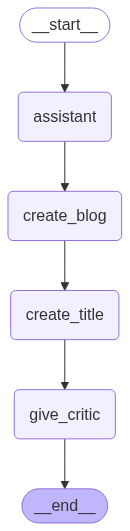

In [245]:
display(Image(react_graph.get_graph().draw_mermaid_png()))


In [246]:
messages = [HumanMessage(content = 'Write a blog on RAG.' )]
messages = react_graph.invoke({'messages':messages})

In [248]:
for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

Write a blog on RAG.
================================== Ai Message ==================================
Tool Calls:
  generate_blog_agent (1sbdne4t1)
 Call ID: 1sbdne4t1
  Args:
    state: {'messages': ['Write a blog on RAG'], 'title': 'RAG: A Comprehensive Guide'}
================================== Ai Message ==================================

**The Silent Killer of Personal Branding: Avoiding the "Expert" Trap**

Are you an expert in your field, yet struggling to stand out on LinkedIn?

In today's noise-filled digital landscape, personal branding is more crucial than ever. However, many professionals fall into the "expert" trap, overemphasizing their credentials and losing sight of what truly resonates with their audience. This approach may boost their ego, but it often repels potential connections and hinders meaningful engagement.

The "expert" trap is characterized by an overreliance on jargon, a focu